In [1]:
import pandas as pd
import numpy as np

from src.populate_db import connect_to_database
from src.analysis_utils import get_words_by_genre, get_word_cloud, get_sentiment


/home/marina/Documents/Projects/MetalExplorer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploring Albums

This notebook will answer some basic questions about the albums in the database:
* How many albums each band released on average?
* When did the most releases happen?
* Do the words in the album titles change depending on genre?
* What are the emotions associated with the albums' titles?

Let's query the database and load the data into a dataframe.

In [2]:
conn = connect_to_database()
cursor = conn.cursor()
cursor.execute("""
               SELECT album.name, band.name, album.release_date, album.duration, 
               YEAR(band.start_date) AS start_year, 
               YEAR(band.end_date) AS end_year, 
               genre.genre_name AS genre  
               FROM album
               INNER JOIN band ON album.band_id = band.id
               INNER JOIN album_genre ON album.id = album_genre.album_id
               INNER JOIN genre ON album_genre.genre_id = genre.id;
               """)
albums = cursor.fetchall()

In [3]:
albums_df = pd.DataFrame(albums, columns=['Album', 'Band', 'Release', 'Duration', 'Band Start', 'Band End', 'Genre'])
albums_df['Band End'] = albums_df['Band End'].replace(np.nan, 2024)
albums_df.drop_duplicates(subset=['Album', 'Band'], inplace=True)

In [ ]:
albums_band_duration = albums_df.dropna(subset=['Band Start'])
albums_band_duration['Band Duration'] = albums_band_duration['Band End'] - albums_band_duration['Band Start']
albums_band_duration.drop(columns=['Band Start', 'Band End'], inplace=True)
albums_band_duration.drop_duplicates(subset=['Album', 'Band'], inplace=True)

## How many albums each band released on average?

A basic description of the number of albums released by band reveals we have some outliers in the data. While 75% of bands released six albums or less, the maximum number of albums by a single band was 53. The frequency distribution of albums by band also shows that the majority of bands released up to three albums.

But some bands have been around for longer than others. Let's check if the band duration is related to the number of albums released!

,Number of Albums
count,2519.000000
mean,4.524017
std,5.202275
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,53.000000


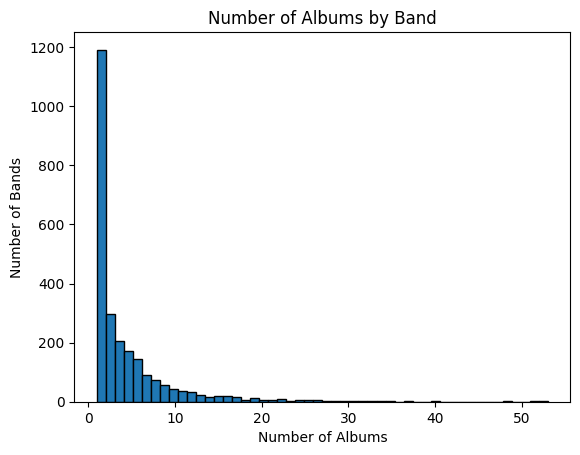

In [5]:
album_count = albums_df.groupby('Band')['Album'].nunique().reset_index()
album_count.columns = ['Band', 'Number of Albums']
album_count['Number of Albums'].plot.hist(
    edgecolor='black', 
    bins=50, 
    xlabel='Number of Albums', 
    ylabel='Number of Bands', 
    title='Number of Albums by Band'
    )
album_count.describe()

The answer is yes, the number of albums is related to how long the band has been active!

The correlation is 43.4%, which means 18.8% of the variation we see in the number of albums can be explained by the duration of the band, but the other 81.2% are due to other factors.

Correlation between Number of Albums and Band Duration:


,Number of Albums,Band Duration
Number of Albums,1.000000,0.433651
Band Duration,0.433651,1.000000


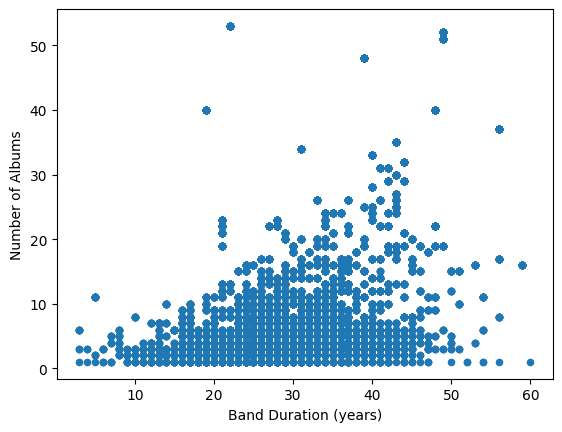

In [6]:
album_count_duration = album_count.merge(albums_band_duration, on='Band')[['Number of Albums', 'Band Duration']]
album_count_duration.plot(kind='scatter', y='Number of Albums', x='Band Duration', xlabel='Band Duration (years)')
print('Correlation between Number of Albums and Band Duration:')
album_count_duration.corr()

## When did the most releases happen?

As we can see there was a steep increase in realeases during the 1980's and 1990's, with a peak in the 2000's. After the 2000's, there is a significant decline in album releases.

This could be explained by a decline in the popularity of metal, but also by a number of iconic bands and musicians breaking up or retiring from this point on.

<Axes: xlabel='Release Decade'>

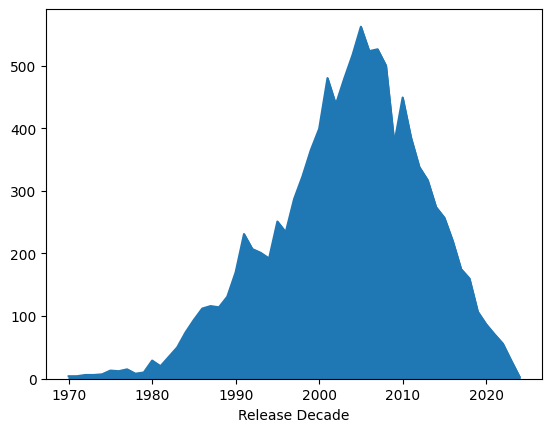

In [7]:
albums_df['Release'] = pd.to_datetime(albums_df['Release']).dt.date
albums_df.dropna(subset=['Release'], inplace=True)
albums_df['Release Decade'] = albums_df['Release'].apply(lambda x: x.year)
albums_df.groupby('Release Decade')['Album'].count().plot.area()

## Do the words in the album titles change depending on genre?

Let's create word clouds for five popular genres in the database to check which words are more frequent in each genre.

Thrash Metal


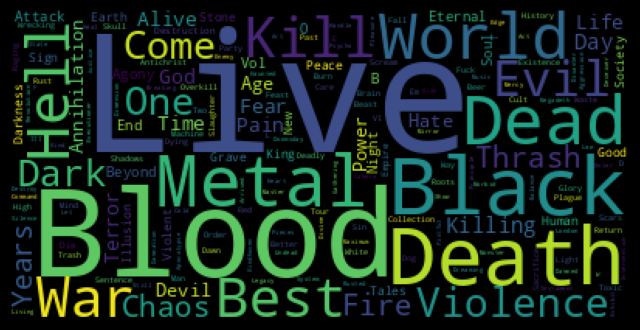

Heavy Metal


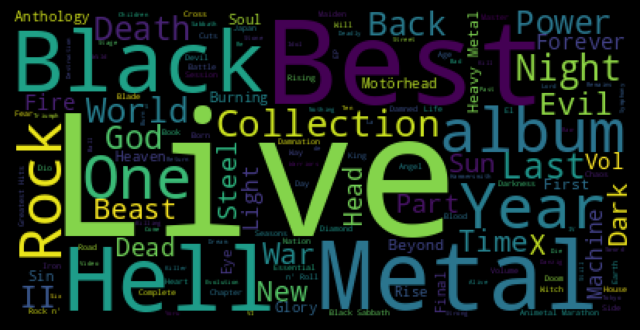

Black Metal


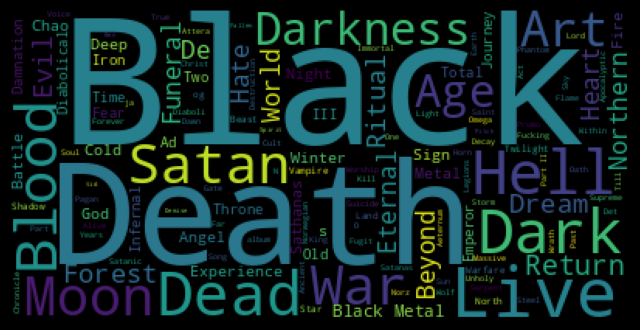

Death Metal


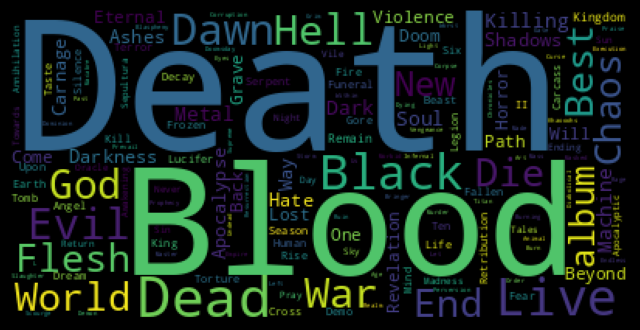

Progressive Metal


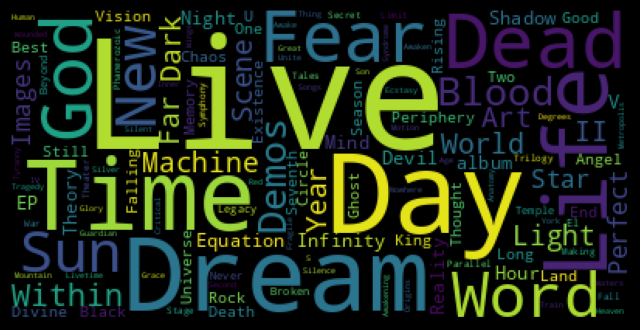

In [8]:
genres = ['thrash metal', 'heavy metal', 'black metal', 'death metal', 'progressive metal']
words = {genre: get_words_by_genre(albums_band_duration, 'Album', genre) for genre in genres}

for genre in genres:
    print(genre.title())
    get_word_cloud(words[genre])

As we can see, many words repeat across genres, such as "dead", "black", and "death", even though they don't always have the same relevance. Another prevalent word is "live" probably due to albums recorded from live concerts.

It is also noteworthy that the progressive metal word cloud has more positive words, such as "life", "sun", "art", and "dream", when compared to the other genres.

## What are the emotions associated with the albums' titles?

To further understand our album titles, let's also perform a [zero-shot classification](https://huggingface.co/tasks/zero-shot-classification) of six emotions (anxiety, depression, happiness, love, anger, and hope) based on the titles by genre. We'll be using [a Facebook's BART checkpoint](https://huggingface.co/facebook/bart-large-mnli) for this task.


In [9]:
labels = ["anxiety", "depression", "happiness", "love", "anger", "hope"]
results = {}

for genre in genres:
    result = get_sentiment(words[genre], labels)
    results[genre] = dict(zip(result['labels'], result['scores']))

Now let's plot the results!

Anxiety was the highest scoring emotion for most of the genres. It's also interesting to see that death metal had the highest scores for depression and anger, probably due to more aggressive album titles, while progressive metal ranks higher for all positive emotions.

It is important to remember, however, that this classification is based in a model trained on general text, so the conclusions we can draw from it are limited. Moreover, fans and non-fans of heavy metal may experience different emotions while listening to violent-themed music ([Thompson et al., 2019](https://psycnet.apa.org/doiLanding?doi=10.1037%2Fppm0000184)).

<Axes: title={'center': 'Emotion by Genre'}, xlabel='Genre', ylabel='Score'>

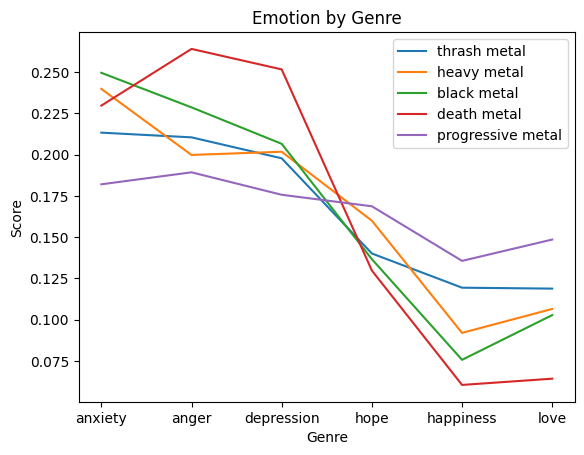

In [10]:
genre_sentiment = pd.DataFrame(results)
genre_sentiment.plot(title='Emotion by Genre', ylabel='Score', xlabel='Genre')